In [1]:
import pandas as pd
import scipy.io
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# https://singlecell.broadinstitute.org/single_cell/study/SCP1852/integrated-multiomic-characterization-of-congenital-heart-disease#study-visualize


# --- File paths ---
in_path = "../data/scRNA_CHD/"
mtx_file       = in_path + "AllNuclei_snRNA_counts.mtx"
rownames_file  = in_path + "AllNuclei_snRNA_counts_rownames.txt"
colnames_file  = in_path + "AllNuclei_snRNA_counts_colnames.txt"
metadata_file  = in_path + "AllNuclei_snRNA_metadata.csv"

# --- Load count matrix ---
print("Loading count matrix...")
X = scipy.io.mmread(mtx_file).tocsr()  # cells x genes (or genes x cells depending on format)

# --- Load feature (gene) names ---
print("Loading row names...")
var_names = pd.read_csv(rownames_file, header=None, sep="\t")[0].astype(str).values

# --- Load cell/sample names ---
print("Loading column names...")
obs_names = pd.read_csv(colnames_file, header=None, sep="\t")[0].astype(str).values

# --- Ensure correct orientation ---
# MatrixMarket usually stores as (genes x cells). 
# We want AnnData with shape (n_obs = cells, n_vars = genes).
if X.shape[0] == len(var_names) and X.shape[1] == len(obs_names):
    # already genes x cells → transpose to cells x genes
    X = X.T
elif X.shape[0] == len(obs_names) and X.shape[1] == len(var_names):
    pass  # already cells x genes
else:
    raise ValueError("Dimension mismatch: check row/col order of .mtx and name files.")

# --- Load metadata ---
print("Loading metadata...")
obs = pd.read_csv(metadata_file, index_col=0)
# Make sure metadata index matches obs_names
obs.index = obs.index.astype(str)
obs = obs.reindex(obs_names)  # align to colnames order

# --- Build AnnData ---
print("Building AnnData object...")
adata = ad.AnnData(
    X=X,
    obs=obs,
    var=pd.DataFrame(index=var_names)
)

# Fill index names
adata.obs_names = obs_names
adata.var_names = var_names

print(adata)


Loading count matrix...
Loading row names...
Loading column names...
Loading metadata...
Building AnnData object...
AnnData object with n_obs × n_vars = 157293 × 29266
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age', 'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region', 'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType', 'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'sex', 'library_preparation_protocol__ontology_label'


/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_30760/1353753558.py:36: DtypeWarning: Columns (2,3,11,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(metadata_file, index_col=0)


In [3]:
adata.obs.columns

Index(['orig_ident', 'nCount_RNA', 'nFeature_RNA', 'labID', 'procedure', 'age',
       'gender', 'echoEF', 'vers10X', 'diagnosis', 'ageCont', 'region',
       'batch_indices', 'percent_mt', 'ClinicalRank', 'DEid', 'MainCellType',
       'Cluster', 'labID2', 'colors', 'Diagnosis', 'patientID', 'cell_id',
       'biosample_id', 'donor_id', 'species', 'species__ontology_label',
       'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label',
       'library_preparation_protocol', 'sex',
       'library_preparation_protocol__ontology_label'],
      dtype='object')

In [4]:
Counter(adata.obs.diagnosis)

Counter({'HLHS': 21050,
         'HTx': 38171,
         'TOF': 15836,
         'LVAD': 27976,
         'Donor': 54260})

In [5]:
Counter(adata.obs.Diagnosis)

Counter({'Neo_HLHS': 6995,
         'HF_HLHS': 30376,
         'TOF': 15836,
         'DCM': 27976,
         'HCM': 21850,
         'Donor': 54260})

In [6]:
Counter(adata.obs.MainCellType)

Counter({'CM': 73296,
         'Neurons': 1985,
         'Adipo': 454,
         'EpiC': 41,
         'Mac': 7010,
         'Tcells': 1121,
         'Mast': 92,
         'Endo': 35673,
         'ENDOC': 1436,
         'LEC': 658,
         'PeriC': 12037,
         'SMC': 2405,
         'EpiL': 51,
         'CF': 21034})

In [7]:
Counter(adata.obs.patientID)

Counter({'P8': 6995,
         'P40': 16321,
         'P26': 2428,
         'P33': 7213,
         'P36': 12906,
         'P64': 14055,
         'P75': 15070,
         'P86': 21850,
         '13_198_LV': 13133,
         'P28': 6195,
         '13_198_RV': 12721,
         '13_235': 11012,
         'UK1': 5158,
         'UK2': 12236})

In [8]:
# Donor = control (baseline, non-diseased human heart)
# HLHS, = Hypoplastic Left Heart Syndrome - congenital defects
# TOF — Tetralogy of Fallot - Another congenital heart defect.
# LVAD — Left Ventricular Assist Device - A mechanical pump surgically implanted in patients with end-stage heart failure.
# HTx = severe acquired heart failure + interventions
for diag in adata.obs.Diagnosis.unique():
    print(diag, adata.obs[adata.obs.Diagnosis == diag]['patientID'].unique())
print('-' * 54)
for diag in adata.obs.diagnosis.unique():
    print(diag, adata.obs[adata.obs.diagnosis == diag]['patientID'].unique())

Neo_HLHS ['P8']
HF_HLHS ['P40' 'P64']
TOF ['P26' 'P33' 'P28']
DCM ['P36' 'P75']
HCM ['P86']
Donor ['13_198_LV' '13_198_RV' '13_235' 'UK1' 'UK2']
------------------------------------------------------
HLHS ['P8' 'P64']
HTx ['P40' 'P86']
TOF ['P26' 'P33' 'P28']
LVAD ['P36' 'P75']
Donor ['13_198_LV' '13_198_RV' '13_235' 'UK1' 'UK2']


# Graph construction

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.covariance import EmpiricalCovariance

def construct_adj_matrix(adata, top_n_genes=2000):
    print("📌 Starting adjacency matrix construction...")

    # --- Copy AnnData to avoid modifying original ---
    print("➡️ Copying AnnData object...")
    ad = adata.copy()

    # --- Gene filtering ---
    print("➡️ Filtering genes with min_cells=10...")
    sc.pp.filter_genes(ad, min_cells=10)
    print(f"Remaining genes after filtering: {ad.n_vars}")

    # --- Normalize ---
    print("➡️ Normalizing total counts per cell (target_sum=1e4)...")
    sc.pp.normalize_total(ad, target_sum=1e4)

    # --- Log transform ---
    print("➡️ Applying log1p transform...")
    sc.pp.log1p(ad)

    # --- Convert to DataFrame ---
    print("➡️ Converting to dense DataFrame (may use large memory)...")
    expr = pd.DataFrame(
        ad.X.toarray() if hasattr(ad.X, "toarray") else ad.X,
        index=ad.obs_names,
        columns=ad.var_names
    )
    print(f"Expression matrix shape: {expr.shape}")

    # --- Fast variance-based HVG selection ---
    print(f"➡️ Selecting top {top_n_genes} highly variable genes (variance filter)...")
    gene_variances = expr.var(axis=0)
    highly_variable = gene_variances.nlargest(top_n_genes).index
    expr_hvg = expr[highly_variable]
    print(f"Selected HVG matrix shape: {expr_hvg.shape}")

    # --- Split into groups ---
    print("➡️ Splitting into groups (case+control vs control)...")
    mask_case_ctrl = ad.obs["diagnosis"].isin(["Donor", "HLHS", "TOF"])
    mask_ctrl = ad.obs["diagnosis"] == "Donor"

    case_ctrl_df = expr_hvg.loc[mask_case_ctrl].T  # genes × cells
    ctrl_df = expr_hvg.loc[mask_ctrl].T            # genes × cells
    expr_hvg_T = expr_hvg.T                        # genes × all cells
    print(f"Case+Control shape: {case_ctrl_df.shape}, Control shape: {ctrl_df.shape}")

    # --- Safe inverse covariance helper ---
    def safe_inverse_cov(X):
        print("   ⏳ Computing covariance...")
        cov = np.cov(X, bias=False)
        print("   ⏳ Inverting covariance matrix...")
        try:
            return np.linalg.inv(cov)
        except np.linalg.LinAlgError:
            print("   ⚠️ Singular covariance, using EmpiricalCovariance...")
            cov_estimator = EmpiricalCovariance().fit(X.T)
            return cov_estimator.precision_

    # --- Compute precision matrices ---
    print("➡️ Computing inverse covariance (case+control)...")
    inv_case_ctrl = safe_inverse_cov(case_ctrl_df)

    print("➡️ Computing inverse covariance (control)...")
    inv_ctrl = safe_inverse_cov(ctrl_df)

    # --- Compute difference matrix ---
    print("➡️ Computing symmetric absolute difference matrix...")
    diff = np.abs(inv_case_ctrl - inv_ctrl)
    diff_df = pd.DataFrame(
        np.maximum(diff, diff.T),
        index=expr_hvg_T.index,
        columns=expr_hvg_T.index
    )

    print("✅ Finished! Adjacency matrix shape:", diff_df.shape)
    return diff_df


diff_df = construct_adj_matrix(adata, top_n_genes=2000)
print(diff_df.shape)

📌 Starting adjacency matrix construction...
➡️ Copying AnnData object...
➡️ Filtering genes with min_cells=10...
Remaining genes after filtering: 27279
➡️ Normalizing total counts per cell (target_sum=1e4)...
➡️ Applying log1p transform...
➡️ Converting to dense DataFrame (may use large memory)...
Expression matrix shape: (157293, 27279)
➡️ Selecting top 2000 highly variable genes (variance filter)...
Selected HVG matrix shape: (157293, 2000)
➡️ Splitting into groups (case+control vs control)...
Case+Control shape: (2000, 91146), Control shape: (2000, 54260)
➡️ Computing inverse covariance (case+control)...
   ⏳ Computing covariance...
   ⏳ Inverting covariance matrix...
➡️ Computing inverse covariance (control)...
   ⏳ Computing covariance...
   ⏳ Inverting covariance matrix...
➡️ Computing symmetric absolute difference matrix...
✅ Finished! Adjacency matrix shape: (2000, 2000)
(2000, 2000)


📌 Building graph from adjacency matrix...
⚠️ Graph too dense: 576210 edges. Keeping top 40000.
📊 Graph Statistics:
   Nodes: 2000
   Edges: 20000
   Avg degree: 20.00
   Max degree: 770
   Connected components: 466


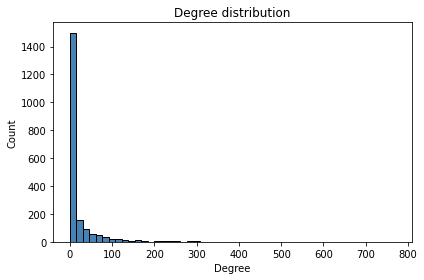

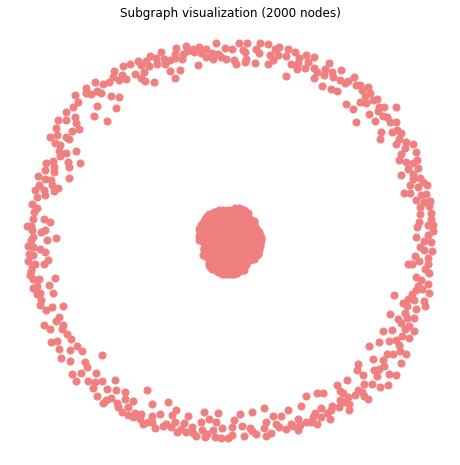

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def graph_stats_and_visualize(adj_df, edge_threshold=0.05, max_edges=5000, subgraph_size=200):
    """
    Build a graph from an adjacency matrix and show statistics + visualizations.

    Parameters
    ----------
    adj_df : pd.DataFrame
        Symmetric adjacency matrix (genes × genes).
    edge_threshold : float
        Minimum edge weight to keep in graph.
    max_edges : int
        Maximum number of edges kept (for speed).
    subgraph_size : int
        Number of nodes to randomly sample for visualization.
    """

    print("📌 Building graph from adjacency matrix...")

    # --- Convert adjacency to graph ---
    A = adj_df.values.copy()
    np.fill_diagonal(A, 0)  # remove self-loops
    edges = np.where(A > edge_threshold)

    G = nx.Graph()
    G.add_nodes_from(adj_df.index)

    # Add edges with weights
    edge_list = list(zip(adj_df.index[edges[0]], adj_df.index[edges[1]], A[edges]))
    if len(edge_list) > max_edges:
        print(f"⚠️ Graph too dense: {len(edge_list)} edges. Keeping top {max_edges}.")
        edge_list = sorted(edge_list, key=lambda x: x[2], reverse=True)[:max_edges]
    G.add_weighted_edges_from(edge_list)

    # --- Graph statistics ---
    degrees = dict(G.degree())
    print("📊 Graph Statistics:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    print(f"   Avg degree: {np.mean(list(degrees.values())):.2f}")
    print(f"   Max degree: {np.max(list(degrees.values()))}")
    print(f"   Connected components: {nx.number_connected_components(G)}")

    # --- Degree distribution ---
    plt.figure(figsize=(6,4))
    plt.hist(list(degrees.values()), bins=50, color="steelblue", edgecolor="k")
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Graph visualization (subgraph) ---
    if subgraph_size < len(G):
        sub_nodes = np.random.choice(G.nodes, size=subgraph_size, replace=False)
        H = G.subgraph(sub_nodes)
    else:
        H = G

    plt.figure(figsize=(8,8))
    pos = nx.spring_layout(H, seed=42)
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color="lightcoral")
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    plt.title(f"Subgraph visualization ({len(H)} nodes)")
    plt.axis("off")
    plt.show()

    return G

G = graph_stats_and_visualize(diff_df, edge_threshold=0.05, max_edges=40000, subgraph_size=2000)

In [ ]:
set(adata.X[1,:].A[0])